In [1]:
import sys
sys.path.append('..')

In [2]:
import dgl
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import Chem
import torch
import math
from dgl import DGLGraph

import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import dgl.function as fn
from functools import partial

In [3]:
from utils.dataset import Dataset
import numpy as np

In [4]:
train_rxn = pd.read_csv('../data/US_patents_1976-Sep2016_1product_reactions_test.csv', header=2, sep='\t')

In [5]:
smarts = train_rxn['OriginalReaction']

In [6]:
def f(x):
    try:
        return x.split('|')[0]
    except Exception:
        return ''

In [7]:
smarts = smarts.apply(f)

In [8]:
dataset = Dataset(smarts[:100], max_num_atoms=200)

In [9]:
rxn = dataset.dataset[0]

In [10]:
mol = rxn.reactants.rdkit_molecule

In [11]:
import rdkit

In [12]:
from rdkit import Chem
def get_molecule_lengths(smarts):
    lengths = []
    for mol_smarts in smarts.split('.'):
        mol = Chem.MolFromSmarts(mol_smarts)
        lengths.append(mol.GetNumAtoms())
    return np.cumsum([0] + lengths)

In [13]:
get_molecule_lengths(rxn.reactants.get_smarts())

array([ 0,  5, 10, 15, 22])

In [14]:
ad_matrix = rxn.reactants.get_adjacency_matrix()

In [15]:
num_ad_matrix = np.zeros_like(ad_matrix, dtype=np.int32)

In [16]:
num2name = {35: 'Br', 6:'C', 8: 'O', 16: 'S', 7:'N', 17: 'Cl', 'SUPER': 'Su'}

In [17]:
nodes = list(rxn.reactants.get_node_types())

In [18]:
nodes_name = [num2name[i] for i in nodes]

In [19]:
print(nodes_name)

['Br', 'C', 'C', 'C', 'O', 'C', 'S', 'Cl', 'O', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'N', 'C', 'C', 'C', 'C', 'C']


In [20]:
num_ad_matrix[ad_matrix=='SINGLE'] = 1
num_ad_matrix[ad_matrix=='DOUBLE'] = 2

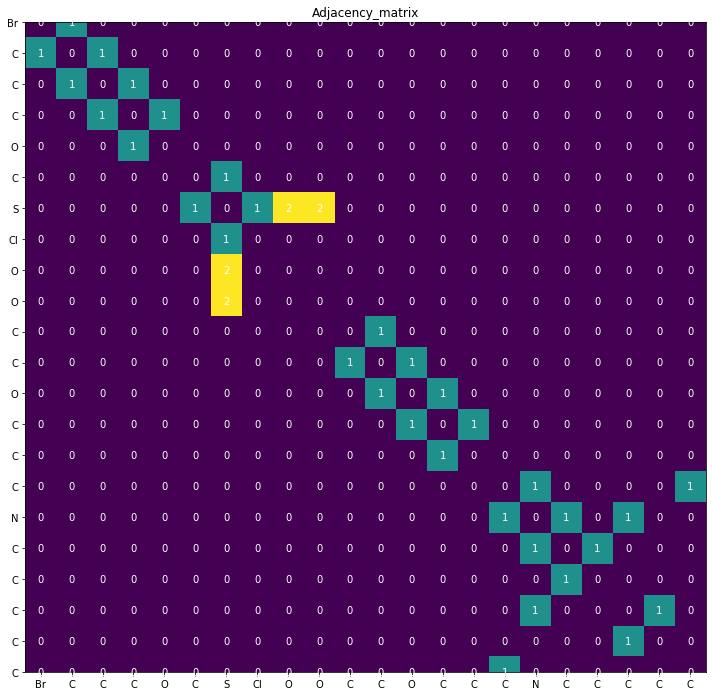

In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(num_ad_matrix)
ax.set_xticks(np.arange(len(nodes_name)))
ax.set_yticks(np.arange(len(nodes_name)))
ax.set_xticklabels(nodes_name)
ax.set_yticklabels(nodes_name)

for i in range(len(nodes_name)):
    for j in range(len(nodes_name)):
        text = ax.text(j, i, num_ad_matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Adjacency_matrix")
fig.tight_layout()
plt.show()

In [23]:
def label2onehot(labels, dim, encoder=None):
    if encoder is not None:
        labels = [encoder(label) for label in labels]
    return np.eye(dim, dtype=np.int32)[labels]

def get_norm(sender, reciever, encoded_types, num_atoms, num_bonds):
    adj_norm = np.zeros((num_atoms, num_bonds), dtype=np.float32)
    for rec, b_type in zip(reciever, encoded_types):
        adj_norm[rec, b_type] += 1
    for rec, b_type in zip(sender, encoded_types):
        adj_norm[rec, b_type] += 1
    adj_norm[adj_norm != 0] =  1./adj_norm[adj_norm != 0]
    idxs = np.c_[[sender, encoded_types]]
    return adj_norm[idxs[0], idxs[1]]

In [24]:
def load_graph_data(rxn, bond2label, node2label):
    sender, reciever, types = rxn.reactants.get_senders_recievers_types()
    encoded_types = [bond2label[t] for t in types]
    nodes = rxn.reactants.get_node_types()
    encoded_nodes = [node2label[node] for node in nodes]
    norm = get_norm(sender, reciever, encoded_types, rxn.reactants.get_num_atoms(), len(bond2label))
    return encoded_nodes, list(sender), list(reciever), encoded_types, list(norm)

In [36]:
device ='cpu'

In [113]:
def get_graph(dataset, idx, n_molecule_level = 1, n_reaction_level = 1, self_bond = True, pad_length=120):
    rxn = dataset.dataset[idx]
    bond_types = list(dataset.reactants_bond_types)
    bond2label = dict(zip(bond_types, range(len(bond_types) )))
    bond2label['SELF'] = len(bond2label)
    for i in range(n_molecule_level):
        bond2label[f'ML_{i}'] = len(bond2label)
    for i in range(n_molecule_level):
        for j in range(n_reaction_level):
            bond2label[f'RL_{i, j}'] = len(bond2label)

    node_types = list(dataset.reactants_node_types)
    node2label = dict(zip(node_types, range(len(node_types))))
    node2label['EMPTY'] = len(node2label)
    
    for i in range(n_molecule_level):
        node2label[f'ML_{i}'] = len(node2label)
    
    for i in range(n_molecule_level):
        for j in range(n_reaction_level):
            node2label[f'RL_{i, j}'] = len(node2label)
    
    nodes, sender, reciever, bonds, norm = load_graph_data(rxn, bond2label, node2label)   
    n_atoms = len(nodes)
    molecules_lengths = get_molecule_lengths(rxn.reactants.get_smarts())
    n_molecules = len(molecules_lengths) - 1
    
    for i in range(n_molecule_level):
        nodes.extend([node2label[f'ML_{i}']]*n_molecules)
        
    for i in range(n_molecule_level):
        for j in range(n_reaction_level):
            nodes.append(node2label[f'RL_{i, j}'])
            
    
    for i in range(n_molecule_level):
        for j, (st, fi) in enumerate(zip(molecules_lengths[:-1], molecules_lengths[1:])):
            sender = sender + list(range(st,fi))
            reciever = reciever + [n_atoms + i*n_molecules + j]*(fi - st)
            bonds = bonds + [bond2label[f'ML_{i}']]*(fi - st)
            
    for i in range(n_molecule_level):
        for j in range(n_reaction_level):
            rg = list(range(n_atoms + i*n_molecules, n_atoms + (i + 1)*n_molecules))
            sender = sender + rg
            
            reciever = reciever + [n_atoms + n_molecule_level*n_molecules + i*n_molecule_level + j]*len(rg)
            bonds = bonds +  [bond2label[f'RL_{i, j}']]*len(rg)
    
    
    norm = norm + [1.]*(len(bonds) - len(norm))
    sender = sender + reciever
    reciever = reciever + sender[:len(reciever)]
    norm = norm + norm
    bonds = bonds + bonds
    nodes = nodes + [node2label['EMPTY']]*(pad_length - len(nodes))
    
    if self_bond:
        sender = sender + list(range(len(nodes)))
        reciever = reciever + list(range(len(nodes)))
        norm = norm + [1.] * len(nodes)
        bonds = bonds + [bond2label['SELF']]  * len(nodes)
    
    g = dgl.DGLGraph()
    g.add_nodes(len(nodes))
    g.ndata['id'] = torch.from_numpy(np.array(nodes)).to(device)
    g.add_edges(np.array(sender), np.array(reciever))
    g.edata['norm'] = torch.from_numpy(np.array(norm).reshape(-1, 1)).to(device).float()
    g.edata['rel_type'] = torch.from_numpy(np.array(bonds)).to(device)
    target = list(dataset.dataset[idx].get_product_mask())
    target = target + [-1]*(len(nodes) - len(target))
    return g, target, node2label

In [118]:
graph, target, node2label = get_graph(dataset, 0, n_molecule_level=1, n_reaction_level=1, pad_length=27)

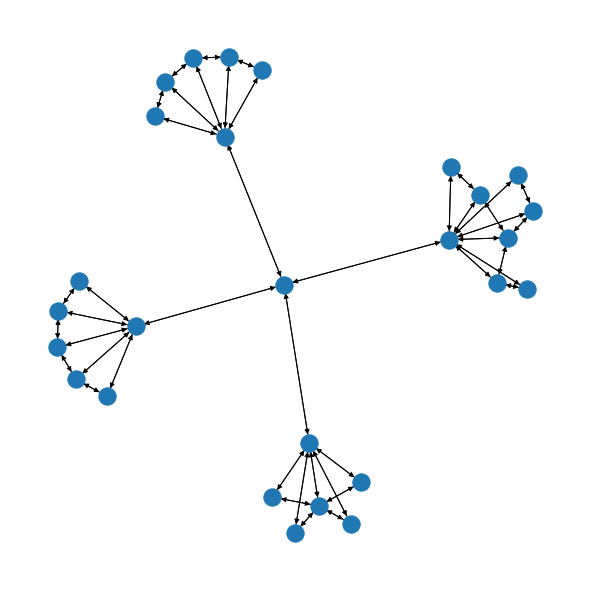

In [119]:
plt.figure(figsize=(8, 8))
nx.draw(graph.to_networkx())

def get_graph(dataset, idx, pad_length, num_super, self_bond = True):
    rxn = dataset.dataset[idx]
    bond_types = list(dataset.reactants_bond_types)
    bond2label = dict(zip(bond_types, range(2, len(bond_types) + 2)))
    bond2label['SELF'] = 0
    bond2label['EXTERNAL'] = 1
    node_types = list(dataset.reactants_node_types)
    node2label = dict(zip(node_types, range(2, len(node_types) + 2)))
    node2label['EMPTY'] = 0
    node2label['SUPER'] = 1
    nodes, sender, reciever, bonds, norm = load_graph_data(rxn, bond2label, node2label)
    n_atoms = len(nodes)
    n_pad = pad_length - n_atoms
    nodes = nodes + [node2label['EMPTY']]*n_pad + [node2label['SUPER']]*num_super
    reciever = reciever + sender
    sender = sender + reciever[:len(sender)]
    norm = norm*2
    bonds = bonds*2
    for s in range(num_super):
        sender = sender + [len(nodes) - s - 1]*n_atoms
        reciever = reciever + list(range(n_atoms))
        reciever = reciever + [len(nodes) - s - 1]*n_atoms
        sender = sender + list(range(n_atoms))
        norm = norm + [1.]*(n_atoms*2)
        bonds = bonds + [1]* (n_atoms*2)
    if self_bond:
        sender = sender + list(range(len(nodes)))
        reciever = reciever + list(range(len(nodes)))
        norm = norm + [1.] * len(nodes)
        bonds = bonds + [0] * len(nodes)
    g = dgl.DGLGraph()
    g.add_nodes(len(nodes))
    g.ndata['id'] = torch.from_numpy(np.array(nodes)).to(device)
    g.add_edges(np.array(sender), np.array(reciever))
    g.edata['norm'] = torch.from_numpy(np.array(norm).reshape(-1, 1)).to(device).float()
    g.edata['rel_type'] = torch.from_numpy(np.array(bonds)).to(device)
    target = list(dataset.dataset[idx].get_product_mask())
    target = target + [-1]*(len(nodes) - len(target))
    return g, target, node2label

In [128]:
device = 'cuda'
g, target, node2label = get_graph(dataset, 0, n_molecule_level=1, n_reaction_level=1, pad_length=27)

In [129]:
nodelist = list(g.ndata['id'].cpu().numpy())

In [130]:
nodelist_num = nodelist

In [131]:
label2node = dict(zip(node2label.values(), node2label.keys()))

In [132]:
nodelist = [label2node[i] for i in nodelist]

In [133]:
nodelist = [num2name[i] for i in nodelist if i in num2name]

In [134]:
nodelist = dict(zip(range(len(nodelist)), nodelist))

/home/socrates/miniconda3/envs/chem/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/socrates/miniconda3/envs/chem/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


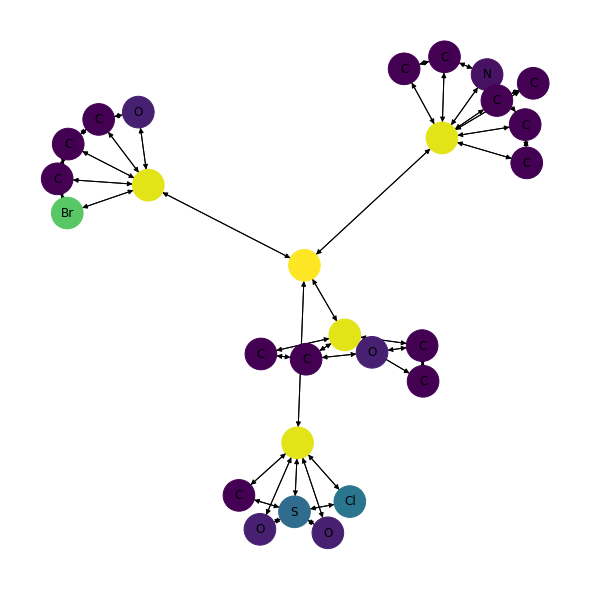

In [135]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
nx.draw(g.to_networkx(), with_labels=True, node_color=nodelist_num, node_size=1000, labels=nodelist)
           

In [86]:
nodelist

[21, 4, 4, 4, 6, 4, 12, 13, 6, 6, 4, 4, 6, 4, 4, 4, 5, 4, 4, 4, 4, 4, 1]